<H1>Reinforcement Learning </H1>

In [1]:
# Space for imports
%pylab inline
figsize(10, 8)

import random

Populating the interactive namespace from numpy and matplotlib


# Gridworld example

The following code will provide you with a working gridworld problem. You are asked to study the code and use it to provide a solution in the following questions. 


In [2]:
class GridWorld: 
    '''
    Class implementing a typical GridWorld problem. 
    
    '''
    
    def __init__(self, width, height, gamma=1, penalty=-1, start=[0,0], goal=[0,0], cliff=[], cliff_penalty=-10):
        '''
        Generates a new Gridworld problem, with a grid of size (width,height). 
        gamma: reward discoount parameter (default:1)
        penalty: penalty for each move (default:-1)
        start: start location (default: [0,0])
        goal: goal location (default: [0,0])
        cliff: list of locations defined as cliff (the agent incurs a large penalty for walking into cliffs and is transported back to the start). 
        cliff_penalty: penalty incurred for walking into a cliff (default: -100). 
        '''
        # define the four possible actions
        self.gamma = gamma
        self.actions = range(4)
        self.delta = np.array([[0,-1],[+1,0],[0,+1],[-1,0]])
        self.actions_labels = ['up','right','down','left']
        
        self.states = range(width*height)

        self.width = width
        self.height = height
        
        # set the start state
        self.start = self.encode_state(start)     

        self.cliff = [self.encode_state(s) for s in cliff]
        self.goal = self.encode_state(goal)
        self.penalty = penalty
        self.cliff_penalty = cliff_penalty
        self.grid = np.zeros((height,width))
        for c in range(width): 
            for r in range(height): 
                if [c,r] == goal: 
                    self.grid[r,c] = 1
                elif [c,r] in cliff: 
                    self.grid[r,c] = 2
                elif [c,r] == start: 
                    self.grid[r,c] = 3
                    
    def action_coordinate(self, action):
        if action in self.actions_labels:
            return self.actions_labels.index(action)
        
    def line_string(self):
        s = '+'
        for j in range(self.width):
            s += '-+'
        s += '\n'
        return s
        
    def tostring(self): 
        '''
            Converts the grid world to a formatted string. 
        '''
        s = 'Grid world:\n'
        for r in range(self.height): 
            s += self.line_string()
            s += '|'
            for c in range(self.width):                 
                if self.grid[r,c] == 1: 
                    s += 'G'
                elif self.grid[r,c] == 2: 
                    s += 'X'
                elif self.grid[r,c] == 3:
                    s += 'S'
                else: 
                    s += ' '
                s += '|'
            s += '\n'
            
        s += self.line_string()
        return s    
    
    def print_solution(self,S): 
        '''
        Graphical display of a solution S, given as a list of states that brings from the initial state to the goal. 
        '''
        s = 'Solution:\n'
        for r in range(self.height): 
            s += self.line_string()
            s += '|'
            for c in range(self.width):                 
                p = self.encode_state((c,r))                
                
                if self.grid[r,c] == 1: 
                    s += 'G'
                elif self.grid[r,c] == 3:
                    s += 'S'
                elif p in S:
                    if p == S[-1]:
                        s += '@'
                    else:
                        s += '*'
                elif self.grid[r,c] == 2: 
                    s += 'X'
                else: 
                    s += ' '
                s += '|'
            s += '\n'
            
        s += self.line_string()
        return s 
    
    def show_states(self):
        '''
        Displays state IDs on a grid. 
        '''
        print( np.array(self.states).reshape((self.width,self.height)).T )
    
    def encode_state(self,coord):
        '''
        Converts a tuple (c,r) containing grid coordinates to the corresponding (scalar) state ID. 
        '''
        (c,r) = coord
        if r<self.height and c<self.width and r>=0 and c>=0: 
            return int(c*self.height+r)
        else: 
            return -1
    
    def decode_state(self,s): 
        '''
        Converts a state ID into grid coordinates. 
        '''
        return (s//self.height,s%self.height)
        
    def state_action_state(self,s,a): 
        '''
        Generates the next state and associated reward for a state/action pair. 
        '''
        
        ns = self.encode_state(self.decode_state(s) + self.delta[a,:])
        
        # If you hit a cliff, go back to the start! Suffer the cliff penalty
        if ns in self.cliff: 
            return (self.start, self.cliff_penalty)
        
        # if an invalid state is generated, stay where we are
        elif ns < 0: 
            return (s,self.penalty)
        
        # if the goal is reached, no penalty incurred. 
        elif ns == self.goal: 
            return (ns,0)
        
        else: 
            return (ns,self.penalty)
        
    def state_transition(self,s): 
        '''
        Generates lists of all possible action/next state/reward triplets for the current state. 
        Returns a triplet of lists (sv,pv,rv), with one element per action, where: 
        sv[a] is the next state following the action a.
        pv[a] is the likelihood to select action a (policy). 
        rv[a] is the immediate reward of selecting action a. 
        '''
        
        sv = np.zeros(len(self.actions),dtype='uint')
        #pv = np.zeros(len(self.actions))
        rv = np.zeros(len(self.actions))
        
        for a in self.actions: 
            (s2,r2) = self.state_action_state(s,a)
            sv[a] = s2
            #pv[a] = 1.0/len(self.actions)
            rv[a] = r2
            
        return (sv,rv)
            
world = GridWorld(6,4, gamma=0.9, goal=[5,3], start=[0,3], cliff=[[1,3],[2,3],[3,3],[4,3]])
print( world.tostring() )
world.state_action_state(2,0)

print('GridWorld state indexing:')
print(world.grid)

world = GridWorld(6,4, gamma=0.9, start=[0,0], goal=[5,3])
print(world.tostring())

np.set_printoptions(precision=2)

world.show_states()

print('Initial value function:')
V = np.zeros(len(world.states))
print(V.reshape((world.width,world.height)).T)

Grid world:
+-+-+-+-+-+-+
| | | | | | |
+-+-+-+-+-+-+
| | | | | | |
+-+-+-+-+-+-+
| | | | | | |
+-+-+-+-+-+-+
|S|X|X|X|X|G|
+-+-+-+-+-+-+

GridWorld state indexing:
[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 3.  2.  2.  2.  2.  1.]]
Grid world:
+-+-+-+-+-+-+
|S| | | | | |
+-+-+-+-+-+-+
| | | | | | |
+-+-+-+-+-+-+
| | | | | | |
+-+-+-+-+-+-+
| | | | | |G|
+-+-+-+-+-+-+

[[ 0  4  8 12 16 20]
 [ 1  5  9 13 17 21]
 [ 2  6 10 14 18 22]
 [ 3  7 11 15 19 23]]
Initial value function:
[[ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]]


In [3]:
class Policy:
    """ Representation of a agents decision making process """
    
    def __init__(self, world: GridWorld, V_function = None, Q_function = None, optimiser=None, epsilon=0.2):
        """ Initialise the policy variables 
        
        Params:
            world - The environment in which the agent acts
            V_function - State values for the environment states
            Q_function - State and action values that can be taken in the environment 
            epsilon - probability of following none value orientated paths
        """
        self.world = world
        
        self.V = V_function
        if optimiser == "V":
            self.V = {s:0 for s in world.states}
        
        self.Q = Q_function
        if optimiser == "Q":
            self.Q = {}
            for state in self.world.states:
                self.Q[state] = {a: 0.0 for s, a in zip(self.world.state_transition(state)[0], self.world.actions_labels) if s != state}

        self.epsilon = epsilon
        
    def run(self) -> [int]:
        """ Return the agents solution to the problem
        
        Returns:
            [int] - A list of state id's indicating a path from state to state
        """
        state = self.world.start # Start the agent in the problems starting position
        path = [state]           # Record agents path
        
        while state != self.world.goal:
            
            # Navigate the path through value towards the goal
            action = self.decision(state)
            state, _ = self.world.state_action_state(state, self.world.action_coordinate(action))
            path.append(state)
            
        return path # Return the solution path
    
    def valueMove(self, state: int) -> int:
        """ For a given state, return the state as dictated by the state with highest value 
        
        Params:
            state - The id of the initial state of the agent
        
        Returns:
            int - The state id of the adjacent state with the highest value
        """
        states, values = self.nextStatesValues(state)
        return states[Policy._max(values)]
        
    def action(self, state: int, _state: int) -> str:
        """ Given back the action responsible for moving from one state to another 
        
        Params:
            state - Initial position state
            _state - The adjacent state
            
        Returns:
            str - The action label responsible for the move 
            
        Raises:
            Error - _state is not an adjacent state
        """
        states, _ = self.world.state_transition(state)
        if _state not in states: raise Error("No action moves from " + str(state) + " to " + str(_state))
        return self.world.actions_labels[list(states).index(_state)]
        
    def probAction(self, state: int, _state: int) -> float:
        """ Calculate the probability of being in a state and moving into an adjacent state
        
        Params:
            state - Initial state of the agent
            _state - The adjacent state the action transitions too
            
        Returns:
            float - The probability of such a move
        """
        return {stateId: probState for stateId, probState in self.probDecision(state)}[_state]
    
    def nextStates(self, state: int) -> [int]:
        """ Return a list of the possible adjacent states the policy would want to move too """
        return self.nextStatesValues(state)[0]
    
    def nextStatesValues(self, state: int) -> ([int], [float]):
        """ Return the next possible states and their values for a 
        given state, for V or Q optimisation
        
        Params:
            state - The id of the state who's adjacent states are desired
            
        Returns:
            int - A collection of state ids of the adjacent states
            float - Their respective value in the policy
            
        Throws:
            Error - If neither a V or Q has been set values cannot be extracted
        """
        states, _ = self.world.state_transition(state)
        
        if self.V is not None:
            states = [s for s in states if s != state]    # Ensure not moving to current state
            return states, [self.V[s] for s in states]
        
        if self.Q is not None:
            Qs = [self.Q[state][action] for i, action in enumerate(self.world.actions_labels) if states[i] != state]
            return [s for s in states if s != state], Qs 
        
        raise Error(str(type(self)) + " has no V or Q function when attempting to find nextStatesValues")
        
    def _max(values: [float]) -> int:
        """ Return the highest valued element of the list, randomly select from the
        the highest value if multiple values are equal.
        
        Params:
            state - List of values representing state worth
            
        Returns:
            int - The index of the choosen value in the list
        """
        return random.choice([i for i in range(len(values)) if values[i] == max(values)])
    
    def Vrepr(self):
        """ Transform the V function into a format to that of the environment """
        return array([self.V[s] for s in self.world.states]).reshape((self.world.width, self.world.height)).T

In [4]:
class GreedyPolicy(Policy):
    """ Policy of moving entirely towards highest value at all times """
    
    def decision(self, state: int) -> str:
        """ The agent's action decision 
        
        Params:
            state - The state id of the agent's initial location
            
        Returns:
            str - The action label of the chosen action
        """
        return self.action(state, self.valueMove(state))
        
    
    def probDecision(self, state: int) -> (int, float):
        """ The probability associated with avaliable actions the agent can take
        
        Params:
            state - The state if of the agent's initial location
            
        Returns:
            (int, float) - State probability combinations of policy thought
        """
        states, values = self.nextStatesValues(state)
        maxValue = max(values)
        maxCount = len([1 for v in values if v == maxValue]) # Count numbers of equal highest valued states
        
        # Generate list of probabilities
        for i, v in enumerate(values):
            values[i] = 0 if v != maxValue else 1/maxCount
        
        # Return
        return zip(states, values)    

In [22]:
class EpsilonGreedyPolicy(Policy):
    """ Policy: Epsilon-Greedy, alternate between greedy and exploritive """
    
    def decision(self, state: int) -> int:
        """ Determine what adjacent state the agent should transition into, given
        a current state.
        
        Params:
            state - State id of the current state
            
        Returns:
            int - The state id of the adjacent state the agent choose
        """
        states, values = self.nextStatesValues(state)
        
        if random.random() > self.epsilon:
            # Choose state with greatest value
            return self.action(state,states[Policy._max(values)])
        
        else:
            # Explore the alternate states
            del states[Policy._max(values)]
            return self.action(state,states[random.randint(0,len(states)-1)])
        
    def probDecision(self, state: int) -> [(int,float)]:
        """ Determine the probabilty for each adjacent state, that hee policy might select it
        
        Params:
            state - The state id of the agent location
            
        Returns:
            [(int,float)] - List of state id - probability pairs.
        """
        
        states, values = self.nextStatesValues(state)

        # Identify the greatest valued adjacent states
        max_indexes = [i for i in range(len(values)) if values[i] == max(values)]
        if len(states) == len(max_indexes):
            # All surrounding states have equal likelihood of being choosen as their value is equal
            return zip(states, [1/len(states)]*len(states))
        
        # Calculate the probabilites for the maximum value state and others.
        prob = [1/(len(states)-len(max_indexes)) * self.epsilon]*len(states)
        for i in max_indexes:
            prob[i] = 1/(len(max_indexes)) * (1 - self.epsilon)
        
        return zip(states, prob)

In [139]:
class ExplorativePolicy(Policy):
    """ Policy: State selection is a function of its value over total value"""
    
    def decision(self, state: int) -> int:
        """ Determine what adjacent state the agent should transition into, given
        a current state.
        
        Params:
            state - State id of the current state
            
        Returns:
            int - The state id of the adjacent state the agent choose
        """
        
        select, prob = random.random(), 0.0 # Collect probabilites for next states
        
        # Iterate through probabilities until random selection occurs
        for nextState, probability in self.probDecision(state):
            prob += probability
            if select <= prob:
                return self.action(state,nextState)
            
    def probDecision(self, state: int) -> int:
        """ Give probability of state selection in respect to the amount of total value available. 
        States with 0 value are explored first. 
        
        Params:
            state - The state id of the agent location
            
        Returns:
            [(int,float)] - List of state id - probability pairs
            """
        
        states, values = self.nextStatesValues(state)
        
        if 0 in values or 0.0 in values:
            count = values.count(0)
            for i, v in enumerate(values):
                values[i] = 0 if v != 0 else 1/count
        else:
            totalValue = abs(sum(values))
            for i, v in enumerate(values):
                values[i] = 1-(abs(v)/totalValue)
            values = [v/sum(values) for v in values]
                
        return zip(states, values)

In [8]:
def policyIteration(world: GridWorld, policy: Policy) -> Policy:
    """ The dynamical programming implementation of the policy iteration function, it takes 
    an initial policy and continues to evaluate and improve said policy until no inconsistances appear 
    between newer iterations of the policy and the current policy.
    
    Params:
        world - The environment in which the policy is acting
        policy - The policy subject to improvement
        
    Returns:
        Policy - A policy that does would remain consistent even after the evaluation function is acted.
    """
    
    iterations = 0 # Iteration counter
    while True:
        
        if iterations in [1,2,5,10]:
            print("Policy V function values after", iterations, "iterations.")
            print(policy.Vrepr())
        
        stable = True                                  # Check on similarity of old and new policy
        newPolicy = type(policy)(world, policy.V)      # Create new policy with old policy's V function
        newPolicy = policyEvaluation(world, newPolicy) # Evaluate the policy and return its improvement
        
        if policy.V != newPolicy.V:
            for state in world.states:
                # For every state check old and new policy align on decision movement
                if policy.valueMove(state) != newPolicy.valueMove(state):
                    stable = False # The policies differ, therefore further improvement is necessary
        
        iterations += 1
        if stable:
            print("System stabalised in", iterations, "iterations.")
            return policy
        else:
            # Replace the old policy with the improved varient
            policy = newPolicy

In [137]:
def policyEvaluation(world: GridWorld, policy: Policy, epsilon=0.01, show=False, printer=False) -> Policy:
    """ Dynamic Programming's policy evaluation method, calculate values for the world states 
    from the agent's policy.
    
    Params:
        world - The environment in which the agent acts
        policy - The policy the agent used to navigate the environment
        epsilon - The learning threshold, signals to stop when iterations provide no improvement.
        
    Returns:
        Policy - The initial policy with updated state value scores.
    """
    
    def recursiveBellman(state: int) -> int:
        """ Recursive Bellman equation implementation to evauluate a particular state of the world
        given the policy.
        
        Params:
            state - integer value representing the current state
        
        Returns:
            int - New calculated value of the original state
        """
        if state == world.goal: 
            return 0 # Reached goal
        
        value = 0.0 # Sum of value for state
        for _state, _reward in zip(*world.state_transition(state)):
            if _state == state: continue # Do not include consider non-moving actions
            value += round(policy.probAction(state,_state)*(_reward + world.gamma*policy.V[_state]), 10)
        return value #/len(policy.nextStates(state)) #Provides greater focus on goal
    
    iterations = 0
    while not printer or (iterations <= 10):
        if printer and iterations in [1,2,5,10]:
            print("Policy Evaluations: After", iterations, "iterations V values are :")
            print(policy.Vrepr())
        delta = 0 # Record of the largest change of state value in each iteration.
        V_current = policy.V.copy() # Create a new copy of the policy's V function for updates
        
        for state in world.states:
            currentValue = V_current[state]            
            V_current[state] = recursiveBellman(state)
            delta = max(delta, abs(currentValue - V_current[state])) # Record largest value change
            
        policy.V = V_current.copy() # Update the policy with the new improvement
        iterations += 1
        
        if (delta < epsilon) and not printer:
            if show: print("Process ended after", iterations, "iterations")
            break # End loop when delta is sufficiently small
    
    return policy

In [11]:
def strictIteration(world: GridWorld, V: [float]) -> [float]:
    V = policyEvaluation(world, GreedyPolicy(world, V_function={s:v for s,v in enumerate(V)})).V
    return [V[i] for i in range(len(world.states))]

## 1. Policy iteration

One way to solve a reinforcement learning problem is to estimate the value function for the whole problem and apply a greedy strategy to find the goal. In the first part you are asked to evaluate the value function V(s) for all states (ie, grid cells), using policy iteration as discussed in class. 

a. Estimate the value of V(s) using policy iteration. Each step of policy iteration will take as parameter the problem to be solved (which will provide the required functions) and the current estimate of the value function (as an array with length equal to the grid size). 

b. Print out the estimated value function after 1,2,5 and 10 iterations. 

c. Provide a solution using a greedy strategy and the estimated value function. Print it out using the print_solution() method.

Criteria
- Does it record what was done in the exercise?
- Does it permit the results to be reproduced?
- How does the work relate to the theoretical foundations discussed in lectures?
- Is it well presented?

### Question 1.a)

Policy iteration as described in the lecture notes is the combination of two policy improvement functions. The first of which is the policy iteration sweep (implemented as policyIteration), that aims to improve a policy by using an arbitrary value improvement function until decisions occur determinisitcally from one iteration to the next. The second is the policy evaluation sweep (implemented as policyEvalutation), that implements the iterative policy evalutation function to generate a new Value function for the policy from changes its initial Values.

It is my intension to use this method with a number of policies and have therefore made its contract take both the environment, and a policy object. To conform to the contract, the function strictIteration is available.

### Question 1.b)

The iterative policy proceedure is able to come to a stable policy by the second iteration, which implies that this method is realistically not necessary for improving the final value.

In [12]:
world = GridWorld(6,4, gamma=0.9, start=[0,0], goal=[5,3])
policy = policyIteration(world, GreedyPolicy(world, optimiser="V"))

print("The V function of the final policy")
print(policy.Vrepr())

Policy V function values after 1 iterations.
[[-5.22 -4.69 -4.1  -3.44 -2.71 -1.9 ]
 [-4.69 -4.1  -3.44 -2.71 -1.9  -1.  ]
 [-4.1  -3.44 -2.71 -1.9  -1.    0.  ]
 [-3.44 -2.71 -1.9  -1.    0.    0.  ]]
System stabalised in 2 iterations.
The V function of the final policy
[[-5.22 -4.69 -4.1  -3.44 -2.71 -1.9 ]
 [-4.69 -4.1  -3.44 -2.71 -1.9  -1.  ]
 [-4.1  -3.44 -2.71 -1.9  -1.    0.  ]
 [-3.44 -2.71 -1.9  -1.    0.    0.  ]]


Utilising the policy evaluation only to look at the values generated, we are able to learn the intrinsic nature of the GridWorld in 10 iterations.

In [13]:
world = GridWorld(6,4, gamma=0.9, start=[0,0], goal=[5,3])
policy = policyEvaluation(world, GreedyPolicy(world, optimiser="V"), printer=True)

Policy Evaluations: After 1 iterations V values are :
[[-1.   -1.   -1.   -1.   -1.   -1.  ]
 [-1.   -1.   -1.   -1.   -1.   -1.  ]
 [-1.   -1.   -1.   -1.   -1.   -0.67]
 [-1.   -1.   -1.   -1.   -0.67  0.  ]]
Policy Evaluations: After 2 iterations V values are :
[[-1.9 -1.9 -1.9 -1.9 -1.9 -1.9]
 [-1.9 -1.9 -1.9 -1.9 -1.9 -1.6]
 [-1.9 -1.9 -1.9 -1.9 -1.6  0. ]
 [-1.9 -1.9 -1.9 -1.6  0.   0. ]]
Policy Evaluations: After 5 iterations V values are :
[[-4.1  -4.1  -4.1  -3.88 -2.71 -1.9 ]
 [-4.1  -4.1  -3.88 -2.71 -1.9  -1.  ]
 [-4.1  -3.88 -2.71 -1.9  -1.    0.  ]
 [-3.88 -2.71 -1.9  -1.    0.    0.  ]]
Policy Evaluations: After 10 iterations V values are :
[[-5.22 -4.69 -4.1  -3.44 -2.71 -1.9 ]
 [-4.69 -4.1  -3.44 -2.71 -1.9  -1.  ]
 [-4.1  -3.44 -2.71 -1.9  -1.    0.  ]
 [-3.44 -2.71 -1.9  -1.    0.    0.  ]]


### Question 1.c)

Provided is a single instance of the method using the policy evaluation technique, and the result it was able to achieve.

The agent has learnt that all down and right combinations are acceptable and equally likely.

In [17]:
# Display multiple grid sizes and goals
for dimensions, goal in [((6,4),[5,3]), ((6,6),[5,5]), ((4,6),[3,5])]:
    w, h = dimensions # Open dimensions of the grid
    print("Policy iteration solution for grid of dimensions (" + str(w) + ", " + str(h) +")")
    
    world = GridWorld(w,h, gamma=0.9, start=[0,0], goal=goal) # Create the Grid world problem
    policy = GreedyPolicy(world, optimiser="V")               # Create the agent's policy
    policy = policyEvaluation(world, policy, show=True)       # Begin optimising the policies V function
    
    # Print results
    print(policy.Vrepr())
    print(world.print_solution(policy.run()))

Policy iteration solution for grid of dimensions (6, 4)
Process ended after 10 iterations
[[-5.22 -4.69 -4.1  -3.44 -2.71 -1.9 ]
 [-4.69 -4.1  -3.44 -2.71 -1.9  -1.  ]
 [-4.1  -3.44 -2.71 -1.9  -1.    0.  ]
 [-3.44 -2.71 -1.9  -1.    0.    0.  ]]
Solution:
+-+-+-+-+-+-+
|S| | | | | |
+-+-+-+-+-+-+
|*|*| | | | |
+-+-+-+-+-+-+
| |*| | | | |
+-+-+-+-+-+-+
| |*|*|*|*|G|
+-+-+-+-+-+-+

Policy iteration solution for grid of dimensions (6, 6)
Process ended after 12 iterations
[[-6.13 -5.7  -5.22 -4.69 -4.1  -3.44]
 [-5.7  -5.22 -4.69 -4.1  -3.44 -2.71]
 [-5.22 -4.69 -4.1  -3.44 -2.71 -1.9 ]
 [-4.69 -4.1  -3.44 -2.71 -1.9  -1.  ]
 [-4.1  -3.44 -2.71 -1.9  -1.    0.  ]
 [-3.44 -2.71 -1.9  -1.    0.    0.  ]]
Solution:
+-+-+-+-+-+-+
|S| | | | | |
+-+-+-+-+-+-+
|*| | | | | |
+-+-+-+-+-+-+
|*|*| | | | |
+-+-+-+-+-+-+
| |*|*|*| | |
+-+-+-+-+-+-+
| | | |*| | |
+-+-+-+-+-+-+
| | | |*|*|G|
+-+-+-+-+-+-+

Policy iteration solution for grid of dimensions (4, 6)
Process ended after 10 iterations
[[-5.22 

## 2. State-Action-Reward-State-Action (SARSA)
In this second part, you are asked to implement the on-policy SARSA algorithm to the problem. Choose an $\epsilon$-greedy policy. Finally, show the solution your algorithm has reached for different values of $\epsilon$.


In [18]:
def SARSA(environment: GridWorld, policy: Policy, episodes=500, alpha=0.1) -> Policy:
    """ State action reward state action reinforcement algorithm 
    
    Params:
        environment - The environment in which the agent operates
        policy - The policy the agent employs to move around the environment
        episodes - The number of iterations of the environment the agent can tranverse
                   before computation stops
        alpha - The learning rate applyied of the next state actions
        
    Returns:
        Policy - A new policy with an improved Q function 
    """
    for cycle in range(episodes):
        
        policy.time = 0.1                      # Reset the policy time variable
        currentState = environment.start       # Collect the starting position
        action = policy.decision(currentState) # Use policy to determine first action
        
        while currentState != environment.goal: # Continue tranversal until the goal is reached
    
            # Collect the next state and reward of the action
            nextState, reward = environment.state_action_state(currentState, environment.action_coordinate(action))
            # Given the next state, determine the subsequent action
            nextAction = policy.decision(nextState)
            
            # Calculate the value of the initial state as a consequence of its value and future action
            policy.Q[currentState][action] =\
                policy.Q[currentState][action] + \
                alpha*(reward + environment.gamma*policy.Q[nextState][nextAction] - policy.Q[currentState][action])
            
            # Move into the new state, and prepare to take the subsequent action
            currentState, action = nextState, nextAction
                        
    return policy

In [19]:
EpsilonValues = [0.1, 0.2, 0.3] # Espilon values used for the Espilon greedy policy

In [26]:
world1 = GridWorld(10,10, gamma=0.9, start=[0,0], goal=[9,9], cliff=[[2,0], [2,1], [2,2], [2,3], [2,4], [2,5], [6,5], [6,6], [6,7],[6,8],[6,9]])

for e in EpsilonValues:
    
    policy = EpsilonGreedyPolicy(world1, epsilon=e, optimiser="Q")  # Create a new policy
    policy = SARSA(world1, policy, episodes=1000)                   # Learn the knowledge from the environment
    solution = policy.run()                                         # Run the policy
    
    print("SARSA function with epsilon greedy policy of epsilon =", e, "took:")
    print(len(solution)-1, "steps to finish")
    print(world1.print_solution(solution))
    

SARSA function with epsilon greedy policy of epsilon = 0.1 took:
28 steps to finish
Solution:
+-+-+-+-+-+-+-+-+-+-+
|S| |X| | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
|*| |X| | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
|*| |X| | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
|*| |X| | |*|*|*|*| |
+-+-+-+-+-+-+-+-+-+-+
|*| |X| |*|*| | |*| |
+-+-+-+-+-+-+-+-+-+-+
|*| |X| |*| |X| |*| |
+-+-+-+-+-+-+-+-+-+-+
|*|*| |*|*| |X| |*| |
+-+-+-+-+-+-+-+-+-+-+
|*|*|*|*| | |X| |*|*|
+-+-+-+-+-+-+-+-+-+-+
| | | | | | |X| | |*|
+-+-+-+-+-+-+-+-+-+-+
| | | | | | |X| | |G|
+-+-+-+-+-+-+-+-+-+-+

SARSA function with epsilon greedy policy of epsilon = 0.2 took:
57 steps to finish
Solution:
+-+-+-+-+-+-+-+-+-+-+
|S| |X| | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
|*| |X| | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
|*| |X| | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
|*| |X| | |*|*|*|*| |
+-+-+-+-+-+-+-+-+-+-+
|*| |X| |*|*| | |*| |
+-+-+-+-+-+-+-+-+-+-+
|*| |X| |*| |X|*|*| |
+-+-+-+-+-+-+-+-+-+-+
|*| | | |*| |X| |*| |
+-+-+-+-+-+-+-+-+-+-+
|*|*|*|*|*| |X| |*|

In [24]:
cliff = [ [i,j] for i in range(3,7) for j in range(3,7) ]
world2 = GridWorld(10,10, gamma=0.9, start=[0,0], goal=[9,9], cliff=cliff)

for e in EpsilonValues:
    
    policy = EpsilonGreedyPolicy(world2, epsilon=e, optimiser="Q")  # Create a new policy
    policy = SARSA(world2, policy, episodes=1000)                   # Learn the knowledge from the environment
    solution = policy.run()                                         # Run the policy
    
    print("SARSA function with epsilon greedy policy of epsilon =", e, "took:")
    print(len(solution)-1, "steps to finish")
    print(world2.print_solution(solution))

SARSA function with epsilon greedy policy of epsilon = 0.1 took:
20 steps to finish
Solution:
+-+-+-+-+-+-+-+-+-+-+
|S|*|*|*|*|*|*|*| | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | |*|*| | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | |*|*|*| |
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X| |*| |
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X| |*| |
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X| |*| |
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X| |*| |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | |*| |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | |*|*|
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |G|
+-+-+-+-+-+-+-+-+-+-+

SARSA function with epsilon greedy policy of epsilon = 0.2 took:
18 steps to finish
Solution:
+-+-+-+-+-+-+-+-+-+-+
|S|*|*|*|*|*| | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | |*|*|*| | |
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | |*|*| |
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X| |*|*|
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X| | |*|
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X| | |*|
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X| | |*|
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |

### Method results

In [216]:
environments = [world1, world2]
iterations = linspace(350,900,10)

worlds = []
for env in environments: # For each environment
    epsValues = []
    for e in EpsilonValues: # For each epsilon value
        solution = []
        for i in iterations: # For each number of episodes
            # Produce a Epsilon-Greedy via the SARSA method
            policy = EpsilonGreedyPolicy(env, epsilon=e, optimiser="Q")
            policy = SARSA(env, policy, episodes=int(i))
            solution.append(len(policy.run()))
        epsValues.append(solution)
    worlds.append(epsValues)

The number of solutions against episodes of function


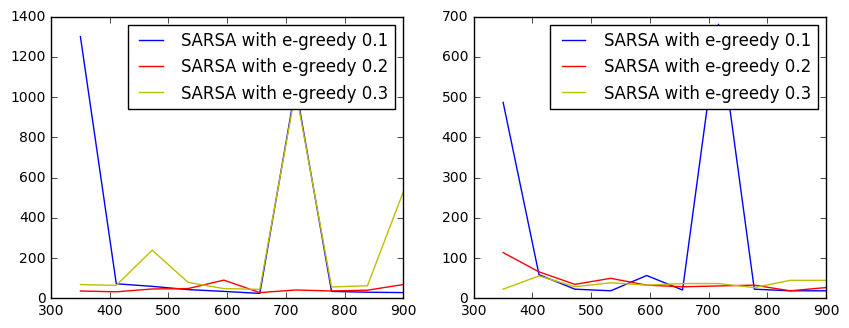

In [218]:
colour = ['b-','r-','y-','g-']
print("The number of solutions against episodes of function")
figure()
for i, env in enumerate(worlds):

    subplot(221 + i)
    for i, epsilonSolutions in enumerate(env):
        plot(list(iterations), epsilonSolutions, colour[i], label="SARSA with e-greedy " + str(EpsilonValues[i]))
    legend()

### Findings

I found that smaller values of epsilon caused the agent to be initially extremely explorative. It is an aspect of this problem that the initialised state carries the highest possible value, and as such, value-driven policies tend to explore initially before tending towards the goal.

For the first 300 episodes, the agent tends to take far more steps than policies with greater epsilon values. However, as the agent has less of a random element to its decision process, after that point it tends to find shorter paths that its rivals. 

This behaviour is a by-product of the negative reward associated with a transition, less travelled routes tend to have a higher value, and the knowledge of the goal point must propagate through many different combinations of actions as a consequence of the explorative nature.

Agents with higher epsilon values have a higher tendency to choose paths already traversed (alternative choice excludes the highest value from possible next steps), this can have very good and very bad effects on the productivity of the agent. With fewer episodes of learning, the agent is reasonably capable of navigating to the goal, however, it is very unlikely for it to ever find an optimal path, as the random component tends to work counter to the knowledge learnt.

We can see that the SARSA has a tendency to avoid being close to the cliff faces, seemingly acting precarious. This stems from the look ahead aspect of the method, the values of these moves are higher due to the potential to alternatively not follow value and transition into the cliff face. This characteristic, in contrast, is not found in Q-learning as it would assume that the agent does not take the cliff action. This is to its detriment as the agent's move are still determined by its policy, and this can still occur.

## 3. Q-learning 
Finally, implement the off-policy Q-learning algorithm and use it to solve the problem. Compare the two algorithms on a number of gridworld configurations and discuss the results. 

In [27]:
def QLearning(world: GridWorld, policy: Policy, episodes=1000, alpha=0.1):
    """ Implement the off policy Q-Learning technique to solve the Grid world problem 
    
    Params:
        world - The environment in which the agent acts
        policy - The agent's decision policy
        episodes - The number of runthroughs the agent has on the board
        alpha - The limiting factor on value change
        
    Returns:
        Policy - The initial policy with an updated and improved Q function
    """
    
    for cycle in range(episodes):
        
        state = world.start       # Start each round on the starting position

        while state != world.goal: # Continue tranversal until the goal is reached
            
            # Use policy to determine action
            action = policy.decision(state)
            # Collect the next state and reward of the action
            nextState, reward = world.state_action_state(state, world.action_coordinate(action))
            
            Qvalue = policy.Q[state][action]
            maxQvalue = max(policy.Q[nextState].values())
            
            # Calculate the value of the initial state as a consequence of its value and future action
            policy.Q[state][action] = Qvalue + alpha*(reward + world.gamma*maxQvalue - Qvalue)
            
            # Move into the new state, and prepare to take the subsequent action
            state = nextState
            
    return policy
    

In [28]:
# Create the grid world problem to solve
cliff = [[i,j] for i in range(3,7) for j in range(3,7)]
world2 = GridWorld(10,10, gamma=0.9, start=[0,0], goal=[9,9], cliff=cliff)

# For each of the epsilon values, learn the environment and plot the learnt path
for epsilon in [0.1, 0.2, 0.3]:
    policy = QLearning(world2, EpsilonGreedyPolicy(world2, epsilon=epsilon, optimiser="Q"), episodes=1000)
    solution = policy.run()
    print("Q-learning function with epsilon greedy policy of epsilon =", epsilon, "took:")
    print(len(solution)-1, "steps to finish")
    print(world2.print_solution(solution))

Q-learning function with epsilon greedy policy of epsilon = 0.1 took:
20 steps to finish
Solution:
+-+-+-+-+-+-+-+-+-+-+
|S|*|*| | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | |*|*|*| | | | | |
+-+-+-+-+-+-+-+-+-+-+
| | | | |*|*|*|*| | |
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X|*| | |
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X|*|*| |
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X| |*| |
+-+-+-+-+-+-+-+-+-+-+
| | | |X|X|X|X| |*|*|
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |*|
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |*|
+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |G|
+-+-+-+-+-+-+-+-+-+-+

Q-learning function with epsilon greedy policy of epsilon = 0.2 took:
26 steps to finish
Solution:
+-+-+-+-+-+-+-+-+-+-+
|S| | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
|*| | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
|*| | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+
|*| | |X|X|X|X| | | |
+-+-+-+-+-+-+-+-+-+-+
|*| | |X|X|X|X| | | |
+-+-+-+-+-+-+-+-+-+-+
|*| | |X|X|X|X| | | |
+-+-+-+-+-+-+-+-+-+-+
|*| | |X|X|X|X| | | |
+-+-+-+-+-+-+-+-+-+-+
|*|*| | |

### Findings

For the Q Learning function, world 1 posed a computationally infeasible problem. It took an unbelieveable amount of time to complete a single episode and thus, could not generate a promising Q function for comparison.

However, when comparing outputs of the second world implementation with the Sarsa process, the Q learning function would seem to generate answers extremely quickly and extremely accurately for identical implementations of the epsilon greedy policy. Additionally the Q-Learning technique can be seen to find shorter but risker paths selecting paths that are adjacent to cliff faces.

## Method and policy comparison

In [71]:
# Map design and generation

# Simplistic map with a single barrier
shield = GridWorld(15,5, gamma=0.9, start=[1,2], goal=[13,2], cliff=[[7,1+i] for i in range(3)] )
print(shield.tostring())

# Complicated map with a surrounding barrier
horseCliff = [[2+i,6] for i in range(5)] + [[2,2+i] for i in range(4)] + [[6,2+i] for i in range(4)]
horseShoe = GridWorld(9,9, gamma=0.9, start=[4,4], goal=[4,7], cliff=horseCliff)
print(horseShoe.tostring())

""" # Used to generate a random field of mines for the third board.
mines = []
for mine in range(20):
    mines.append([round(random.random()*15), round(random.random()*15)])
print(mines)
"""

# Erratic map, relatively simple but noticable larger.
minefield = GridWorld(15, 15, gamma=0.9, start=[2,2], goal=[13,13], cliff=[[13, 3], [7, 5], [11, 3], [9, 9], [1, 9], [2, 10], [10, 11], [4, 4], [3, 13], [6, 1], [0, 2], [7, 1], [12, 11], [5, 14], [10, 4], [1, 2], [8, 5], [8, 14], [6, 8], [7, 4]])
print(minefield.tostring())

Grid world:
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | | | | | |X| | | | | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
| |S| | | | | |X| | | | | |G| |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | | | | | |X| | | | | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+

Grid world:
+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |
+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |
+-+-+-+-+-+-+-+-+-+
| | |X| | | |X| | |
+-+-+-+-+-+-+-+-+-+
| | |X| | | |X| | |
+-+-+-+-+-+-+-+-+-+
| | |X| |S| |X| | |
+-+-+-+-+-+-+-+-+-+
| | |X| | | |X| | |
+-+-+-+-+-+-+-+-+-+
| | |X|X|X|X|X| | |
+-+-+-+-+-+-+-+-+-+
| | | | |G| | | | |
+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |
+-+-+-+-+-+-+-+-+-+

Grid world:
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | | | | |X|X| | | | | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
|X|X|S| | | | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | 

### Effect of policy on method

In [206]:
import time

mapScores = []
for gridmap in [shield,horseShoe, minefield]:
    print("M", end="")
    methodScores = []
    for method in [(policyEvaluation, "V"), (SARSA, "Q"), (QLearning, "Q")]:
        print("X", end="")
        pmethodScores = []
        for policyMethod in [GreedyPolicy, EpsilonGreedyPolicy, ExplorativePolicy]:
            print("I", end="")

            start = time.time()
            
            if (gridmap in [shield, horseShoe,minefield] and method[0] == SARSA and policyMethod == GreedyPolicy) or \
               (gridmap in [horseShoe, minefield] and method[0] == QLearning) or \
               (gridmap == minefield and method[0] == SARSA and policyMethod == ExplorativePolicy):
                solution = []
            else:
                policy = policyMethod(gridmap, epsilon=0.1, optimiser=method[1])
                policy = method[0](gridmap, policy)
                solution = policy.run()

            finish = time.time() - start
            pmethodScores.append((finish, len(solution), solution))
        methodScores.append(pmethodScores)   
    mapScores.append(methodScores)

MXIIIXIIIXIII

In [215]:
mapname = ["Shield", "Horse shoe", "Minefield"]

for i, methodScores in enumerate(collection):
    
    print("========")
    print(mapname[i])
    print("========")
    print("Path Length\tGreedy\t\tEpsilon\t\tExplorative")
    print("-"*60)
    print("Evaluation\t"+str(methodScores[0][0][1]), "\t\t"+str(methodScores[0][1][1]), "\t\t"+str(methodScores[0][2][1]))
    print("SARSA\t\t"+str(methodScores[1][0][1]), "\t\t"+str(methodScores[1][1][1]), "\t\t"+str(methodScores[1][2][1]))
    print("QLearning\t"+str(methodScores[2][0][1]), "\t\t"+str(methodScores[2][1][1]), "\t\t"+str(methodScores[2][2][1]))
    print()
    
    print("Time\t\tGreedy\t\tEpsilon\t\tExplorative")
    print("-"*60)
    print("Evaluation\t"+str(round(methodScores[0][0][0],3)), "\t\t"+str(round(methodScores[0][1][0],3)), "\t\t"+str(round(methodScores[0][2][0],3)))
    print("SARSA\t\t"+str(round(methodScores[1][0][0],3)), "\t\t"+str(round(methodScores[1][1][0],3)), "\t\t"+str(round(methodScores[1][2][0],3)))
    print("QLearning\t"+str(round(methodScores[2][0][0],3)), "\t\t"+str(round(methodScores[2][1][0],3)), "\t\t"+str(round(methodScores[2][2][0],3)))
    print()

Shield
Path Length	Greedy		Epsilon		Explorative
------------------------------------------------------------
Evaluation	17 		21 		4501
SARSA		0 		97 		1247
QLearning	17 		32 		128

Time		Greedy		Epsilon		Explorative
------------------------------------------------------------
Evaluation	0.246 		0.518 		1.491
SARSA		0.0 		1.699 		59.868
QLearning	2.058 		2.209 		85.425

Horse shoe
Path Length	Greedy		Epsilon		Explorative
------------------------------------------------------------
Evaluation	16 		22 		4906
SARSA		0 		22 		3141
QLearning	0 		0 		0

Time		Greedy		Epsilon		Explorative
------------------------------------------------------------
Evaluation	0.27 		0.407 		1.628
SARSA		0.0 		1.775 		205.189
QLearning	0.0 		0.0 		0.0

Minefield
Path Length	Greedy		Epsilon		Explorative
------------------------------------------------------------
Evaluation	23 		29 		14462
SARSA		0 		422 		0
QLearning	0 		0 		0

Time		Greedy		Epsilon		Explorative
-------------------------------------------------

In [86]:
policy = policyEvaluation(shield, EpsilonGreedyPolicy(shield, epsilon=0.1, optimiser="V"), show=True)
print(shield.print_solution(policy.run()))
policy = policyEvaluation(horseShoe, EpsilonGreedyPolicy(horseShoe, epsilon=0.1, optimiser="V"), show=True)
print(horseShoe.print_solution(policy.run()))
policy = policyEvaluation(minefield, EpsilonGreedyPolicy(minefield, epsilon=0.1, optimiser="V"), show=True)
print(minefield.print_solution(policy.run()))

Process ended after 39 iterations
Solution:
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | |*| |*|*|*|*|*|*|*|*| | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | |*|*|*| |X| | | | |*|*| |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
| |S|*|*| | | |X| | | | | |G| |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | | | | | |X| | | | | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+

Process ended after 28 iterations
Solution:
+-+-+-+-+-+-+-+-+-+
|*|*|*|*|*| | | | |
+-+-+-+-+-+-+-+-+-+
|*| | | |*| | | | |
+-+-+-+-+-+-+-+-+-+
|*| |X| |*| |X| | |
+-+-+-+-+-+-+-+-+-+
|*| |X| |*| |X| | |
+-+-+-+-+-+-+-+-+-+
|*| |X| |S| |X| | |
+-+-+-+-+-+-+-+-+-+
|*| |X| | | |X| | |
+-+-+-+-+-+-+-+-+-+
|*| |X|X|X|X|X| | |
+-+-+-+-+-+-+-+-+-+
|*|*|*|*|G| | | | |
+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |
+-+-+-+-+-+-+-+-+-+

Process ended after 39 iterations
Solution:
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | | | | |X|X| | | | | | | |
+-+-+-

In [77]:
policy = SARSA(shield, EpsilonGreedyPolicy(shield, epsilon=0.1, optimiser="Q"), episodes=500)
print(shield.print_solution(policy.run()))

Solution:
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | | |*|*|*|*|*|*| | | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | |*|*|*| | |X| |*| | | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
| |S|*| | | | |X| |*|*|*|*|G| |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | | | | | |X| | | | | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+



In [80]:
policy = SARSA(horseShoe, EpsilonGreedyPolicy(horseShoe, epsilon=0.1, optimiser="Q"), episodes=500)
print(horseShoe.print_solution(policy.run()))

Solution:
+-+-+-+-+-+-+-+-+-+
| |*|*|*|*| | | | |
+-+-+-+-+-+-+-+-+-+
|*|*| | |*| | | | |
+-+-+-+-+-+-+-+-+-+
|*| |X| |*| |X| | |
+-+-+-+-+-+-+-+-+-+
|*| |X| |*| |X| | |
+-+-+-+-+-+-+-+-+-+
|*| |X| |S| |X| | |
+-+-+-+-+-+-+-+-+-+
|*| |X| |*| |X| | |
+-+-+-+-+-+-+-+-+-+
|*| |X|X|X|X|X| | |
+-+-+-+-+-+-+-+-+-+
|*|*|*|*|G| | | | |
+-+-+-+-+-+-+-+-+-+
| | | | | | | | | |
+-+-+-+-+-+-+-+-+-+



In [82]:
policy = SARSA(minefield, EpsilonGreedyPolicy(minefield, epsilon=0.1, optimiser="Q"), episodes=500)
print(minefield.print_solution(policy.run()))

Solution:
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
|*|*|*|*|*| | | | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
|*|*|*|*|*|*|X|X| | | | | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
|X|X|S|*|*|*|*| | | | | | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | |*| |*| |*| | | | |X| |X| |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
| |*|*| |X|*|*|X| | |X| | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
|*|*| | |*|*|*|X|X| | | | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
|*|*|*|*|*|*|*|*|*| | | | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | |*|*|*| | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | | | | |X| | |*|*| | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
| |X| | | | | | | |X|*| | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | |X| | | | | | | |*|*|*|*| |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | |X| |X|*| |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | | | | | | | | | | | |*| |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | |X| | | | | | | | | |G| |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-+
| | | | | |X| | |X| | | | | | |
+-+-+-+-+-+-+-+-+-+-+-+-+-+-+-

### End comparison

When comparing the various methods, it is easy to see that policy evaluation iteration provides the best results in the shortest time with the greatest flexibility. Through its operation, it focuses attention on perfecting the V function for the states of the environments with respect to the policies view. The V function for a particular policy tends to push an agent towards a set of actions for a particular environment, making differing policies have similar characteristics. It does, however, seem to suffer from more explorative/random approaches, as it cannot overcompensate for actions.

This is leaps and bounds above the method Q Learning, that within 500 episodes was very slow and unoptimal for the easiest case and unfeasible for the remaining Grid worlds. What was surprising was its combination with the explorative policy. As Q-learning determines the value for state/actions in an expression that contains the best future action rather than the future action of the policy, it's behaviour becomes more evident. The Random explorative nature of the policy is driven by the value deltas of the adjacent states, and since the value is being determined quite accurately without the impact of the explorative randomness. It better leads the agent to the goal. Equally, the randomness in the policy helps to ensure that it traverses lots of the space without getting stuck.

The SARSA method was relatively promising, but it is definitely suited to having a small element of randomness in its traversal. The greedy policy continued to lead the agent into a loop and due to its lack of compromise, that meant that such a combination was never viable. Furthermore, Its large time required when using the explorative policy indicates that the epsilon-greedy approach with an epsilon value around 0.1-0.2 is likely best. With that, the method gets very good near-optimal results.

SARSA and Q-Learning definitely seem to have some advantages over the other when considering the type of problem that is being faced. Q-Learning is able to generate more optimal paths for lower iterations on simplistic Grids. A by-product of its value only look ahead, it is risky, and this benefits it on simple courses. Whereas SARSA can produce very optimal results if given enough time to solve a problem, and for difficult tasks, is much better and navigating them in quicker time with a near-optimal route. This is because SARSA better learns to avoid cliffs through its look ahead expression including the policies aspects, where the Q-learning approach would never consider them and fall in. 